# Rona Habibi

# My Research Question
**Is there a distinct relationship between natural disasters, carbon dioxide emissions and average temperatures across continents?  Can we assume that the natural disasters are induced by the climate crisis?**

There's no doubt that the climate crisis doesn't exist. I am interested in exploring data representing types of natural disasters, along with global average temperatures and global emission rates from as a early as the 1970's. With these three data sets, I would like to see if there is any pattern between the change in natural disasters over the years that may be related to a similar pattern in CO2 emission rates and/or temperatures. This topic interests me, because the increase is natural disasters have gotten more sever over time, yet leaders are not adressing its relationship to the climate crises, hence why I am examining this relationship in this analysis.

### Import statements:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc

In [ ]:
#xyz = project_functionsRona.num_nd_yearly()
import sys
sys.path.append('..')
from analysis.code import project_functionsRona as pt

# Loading my datasets:

In [ ]:
df_nd = pd.read_csv("../data/raw/1900_2021_DISASTERS.csv") # Natural Disasters dataframe
df_emis = pd.read_csv("../data/raw/owid_emissions.csv") # Emissions dataframe
df_temp = pd.read_csv("../data/processed/processedTemperatureData.csv")

# Cleaning, Processing, and Wrangling Data

My goal for cleaning the three following data sets is to eliminate any unnecessary data that is not the focus of my research interest. For each data set, there will be different kinds of processing, but my main focus is to create columns in each dataset comparing one year to it's recent, and group the data by continents.

### Natural Disasters

In [ ]:
def processed_nd_data():
    df_ndperyear = (pd.read_csv("../data/raw/1900_2021_DISASTERS.csv")
                      .query('`Disaster Type` in ["Flood", "Storm", "Drought", "Wildfire", "Landslide"]')
                      .iloc[:, [1, 5, 6, 10, 12, 13]]
                      .dropna()
                      .groupby(['Year', 'Continent', 'Disaster Type'])
                      .size()
                      .reset_index(name='Number of Disasters')
                      .assign(Difference_from_Previous_Year=lambda x: x.groupby('Disaster Type')['Number of Disasters'].diff(),
                              Percent_Difference_from_Previous_Year=lambda x: (x['Difference_from_Previous_Year'] / x.groupby('Disaster Type')['Number of Disasters'].shift(1)) * 100)
                      .rename(columns={'Percent_Difference_from_Previous_Year': '% Difference from Previous Year'})
                      .rename(columns={'Difference_from_Previous_Year': 'Difference from Previous Year'})
                      .dropna()
                    )
    return df_ndperyear
processed_nd_data()

,Year,Continent,Disaster Type,Number of Disasters,Difference from Previous Year,% Difference from Previous Year
3,1970,Americas,Drought,1,0.0,0.000000
4,1970,Americas,Flood,15,13.0,650.000000
5,1970,Americas,Storm,7,6.0,600.000000
7,1970,Asia,Flood,11,-4.0,-26.666667
9,1970,Asia,Storm,14,7.0,100.000000
...,...,...,...,...,...,...
1014,2021,Europe,Wildfire,5,3.0,150.000000
1015,2021,Oceania,Drought,1,-4.0,-80.000000
1016,2021,Oceania,Flood,5,-16.0,-76.190476
1017,2021,Oceania,Storm,6,-2.0,-25.000000


### Emissions

While cleaning and wrangling the emissions data, i noticed there was no column indicating continents. Since I am focusing on continents for my research question, I have refered to this [site](https://towardsdatascience.com/matching-country-information-in-python-7e1928583644) for importing a function that allows me create a column of continents and places each country in a continent based on the ISO name system. Note that we need to install pycountry_convert in our terminal before importing

In [ ]:
# Let's define a function to get the continent name for a given country name
def get_continent(country):
    try:
        country_code = pc.country_name_to_country_alpha2(country, cn_name_format="default")
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return "Unknown"


In [ ]:
def preprocess_emissions_data():
    df_emis = pd.read_csv("../data/raw/owid_emissions.csv")
    df_emis = (df_emis.drop(df_emis[df_emis["year"] < 1970].index)
              .iloc[:, [0, 1, 3, 7, 9]]
              .sort_values(by='year')
              .assign(continent=lambda x: x["country"].apply(get_continent)) #this function was created just above ^
              .query('continent != "Unknown"')
              .dropna()
              .rename(columns = {'year':'Year'})
              .rename(columns={'continent':'Continent'})
              .rename(columns={'co2_growth_prct': '% Difference from Previous Year'}))
    return df_emis
preprocess_emissions_data()

,country,Year,population,co2,% Difference from Previous Year,Continent
120,Afghanistan,1970,10752973.0,1.670,77.469,Asia
28028,Morocco,1970,15274357.0,7.282,25.177,Africa
42537,Turkey,1970,35540988.0,42.579,9.874,Asia
45135,Vanuatu,1970,87038.0,0.040,-8.333,Oceania
20258,Indonesia,1970,115228392.0,35.791,7.281,Asia
...,...,...,...,...,...,...
38644,South Africa,2021,59392256.0,435.929,0.022,Africa
28423,Myanmar,2021,53798088.0,36.307,0.604,Asia
38472,Somalia,2021,17065588.0,0.610,5.553,Africa
28595,Namibia,2021,2530150.0,4.015,1.766,Africa


### Temperature

In [ ]:
def preprocess_temperature_data():
    americas_cont = { #changing so the continents can be the same as the natural disasters dataframe
        'North America': 'Americas',
        'Central America': 'Americas',
        'South America': 'Americas'
    }

    df_temp = pd.read_csv("../data/processed/processedTemperatureData.csv")
    df_temp = (df_temp.drop(df_temp[df_temp["year"] < 1970].index)
                   .assign(Continent=lambda x: x["Country"].apply(get_continent)
                           .replace(americas_cont))  # Include mapping and replacement step
                   .query('Continent != "Unknown"')
                   .drop('Unnamed: 0', axis=1)
                   .assign(temperature_difference=lambda x: x['AverageTemperature'] -
                           x.groupby('Country')['AverageTemperature'].shift(1),
                           pct_temperature_difference=lambda x: x['temperature_difference'] /
                           x['AverageTemperature'] * 100 )
                   .dropna()
                   .rename(columns={'year':'Year'})
                   .rename(columns={'pct_temperature_difference': '% temp difference'}))
               
    return df_temp
preprocess_temperature_data()

,Year,Country,AverageTemperature,Continent,temperature_difference,% temp difference
37794,1971,Afghanistan,14.823500,Asia,0.040417,0.272653
37796,1971,Albania,12.534417,Europe,-0.305250,-2.435295
37797,1971,Algeria,22.672250,Africa,-0.650583,-2.869514
37798,1971,American Samoa,26.402250,Oceania,-0.358417,-1.357523
37799,1971,Andorra,11.192167,Europe,-0.184417,-1.647730
...,...,...,...,...,...,...
48235,2013,Venezuela,25.912875,Americas,0.224292,0.865561
48236,2013,Vietnam,25.232125,Asia,0.527792,2.091745
48239,2013,Yemen,28.129750,Asia,0.684750,2.434256
48240,2013,Zambia,21.196000,Africa,-0.501750,-2.367192


#### Let's move around with our cleaned and processed data before we make our visuals:

In [ ]:
df1 = processed_nd_data()
df2 = preprocess_emissions_data()
df3 = preprocess_temperature_data()

In [ ]:
df12 = pd.merge(df1, df2, on='Year') # emissions and nat disasters
df13= pd.merge(df1, df3, on = "Year") #temp & nat disasters

In [ ]:
df1

,Year,Continent,Disaster Type,Number of Disasters,Difference from Previous Year,% Difference from Previous Year
3,1970,Americas,Drought,1,0.0,0.000000
4,1970,Americas,Flood,15,13.0,650.000000
5,1970,Americas,Storm,7,6.0,600.000000
7,1970,Asia,Flood,11,-4.0,-26.666667
9,1970,Asia,Storm,14,7.0,100.000000
...,...,...,...,...,...,...
1014,2021,Europe,Wildfire,5,3.0,150.000000
1015,2021,Oceania,Drought,1,-4.0,-80.000000
1016,2021,Oceania,Flood,5,-16.0,-76.190476
1017,2021,Oceania,Storm,6,-2.0,-25.000000


# Visuals


[Text(0.5, 1.0, 'Number of Natural Disasters in Comparision to Previous Year')]

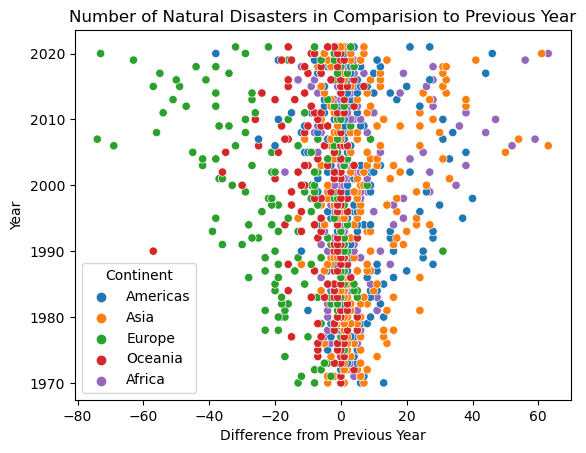

In [ ]:
sns.scatterplot(data = df1, x= "Difference from Previous Year",y = "Year", hue= "Continent").set(title="Number of Natural Disasters in Comparision to Previous Year")


From this scatterplot, we can see which continents have gotten an increase of natural disasters versus which continents have a recorded decrease. Here we see Europe with a noticable decrease in natural disasters each year since 1970 (on the left side), with a couple outliers, and less noticably Oceania. On the right side, we see an increase in Asia, the Americas, and Africa. We are going to take a closer look on these continents and compare to emissions and temperatures to see if there seems to be a relationship.

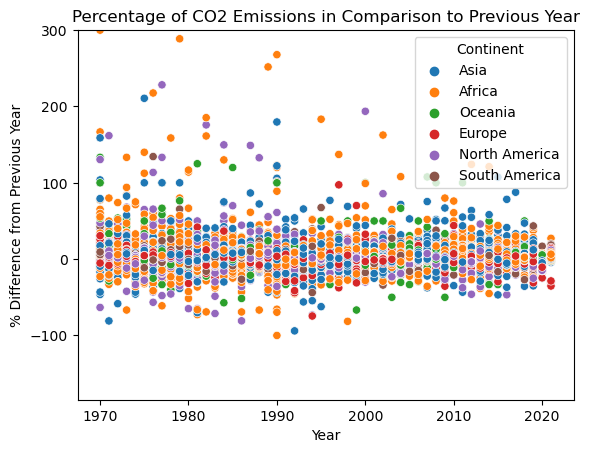

In [ ]:
sns.scatterplot(data=preprocess_emissions_data(), x="Year", y="% Difference from Previous Year", hue="Continent").set(title="Percentage of CO2 Emissions in Comparison to Previous Year")
plt.ylim(ymax=300)
plt.show()

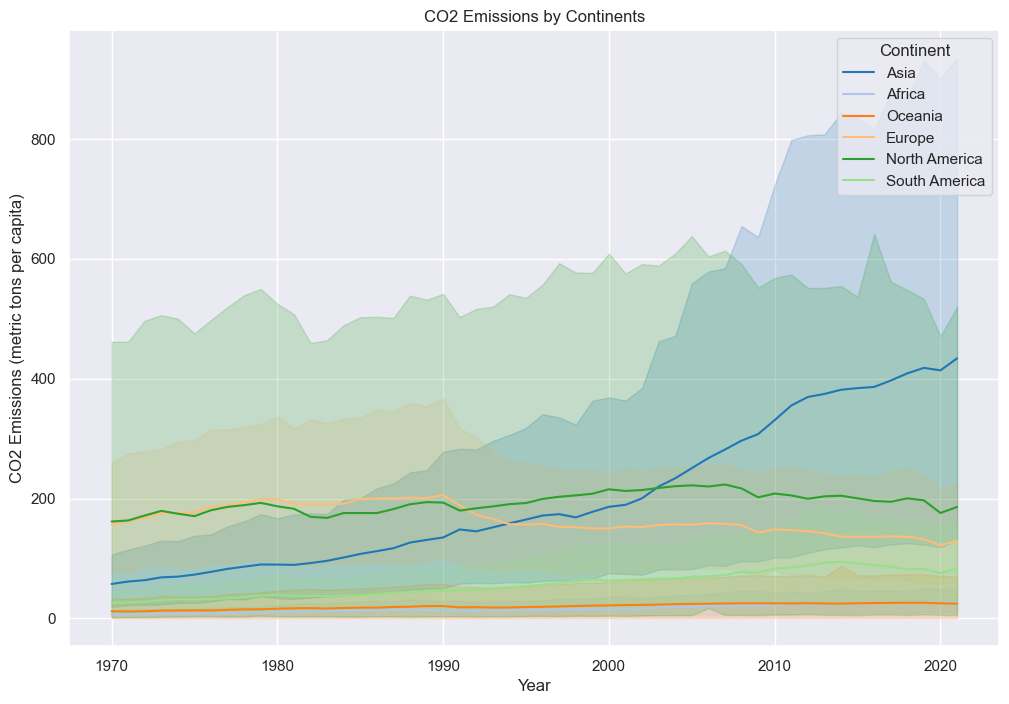

In [ ]:
df2 = preprocess_emissions_data()
sns.set_theme()
plt.figure(figsize=(12, 8))
sns.lineplot(data=df2, x="Year", y="co2", hue="Continent", palette="tab20")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (metric tons per capita)")
plt.title("CO2 Emissions by Continents")
plt.show()

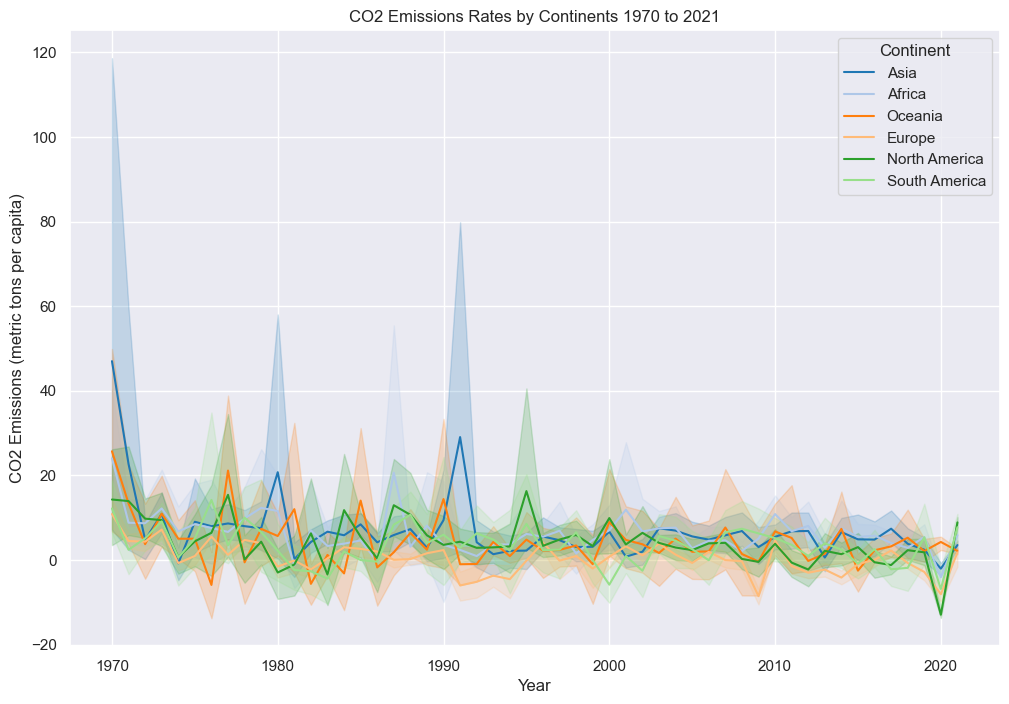

In [ ]:
df2 = preprocess_emissions_data()
sns.set_theme()
plt.figure(figsize=(12, 8))
sns.lineplot(data=df2, x="Year", y="% Difference from Previous Year", hue="Continent", palette="tab20")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (metric tons per capita)")
plt.title("CO2 Emissions Rates by Continents 1970 to 2021")
plt.show()

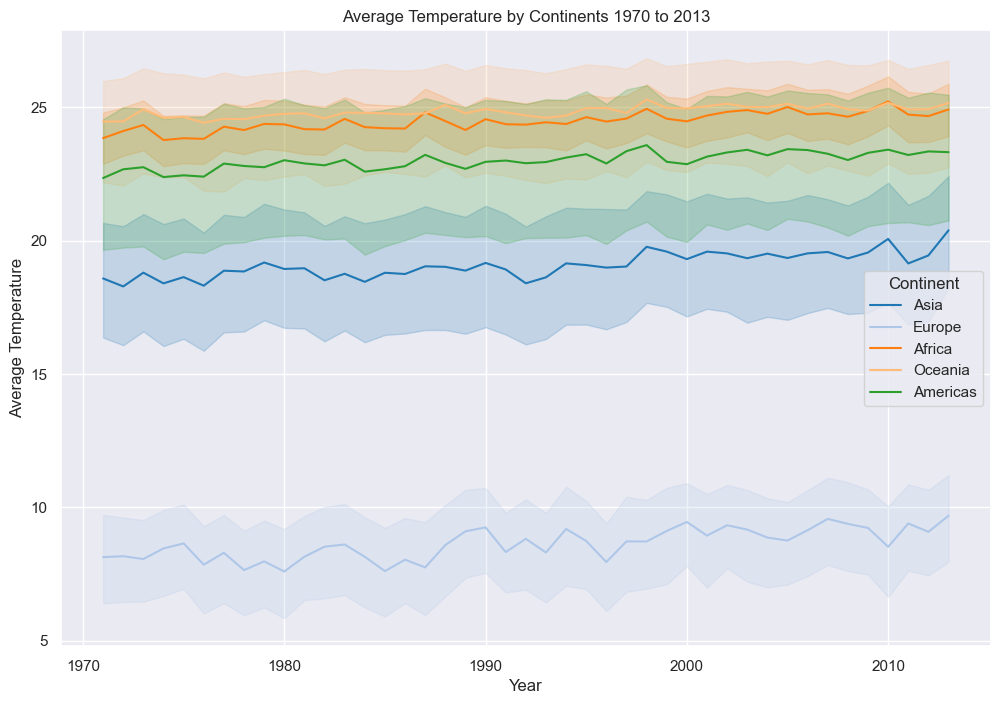

In [ ]:
sns.set_theme()
plt.figure(figsize=(12, 8))
sns.lineplot(data=df3, x="Year", y="AverageTemperature", hue="Continent", palette="tab20")
plt.xlabel("Year")
plt.ylabel("Average Temperature")
plt.title("Average Temperature by Continents 1970 to 2013")
plt.show()

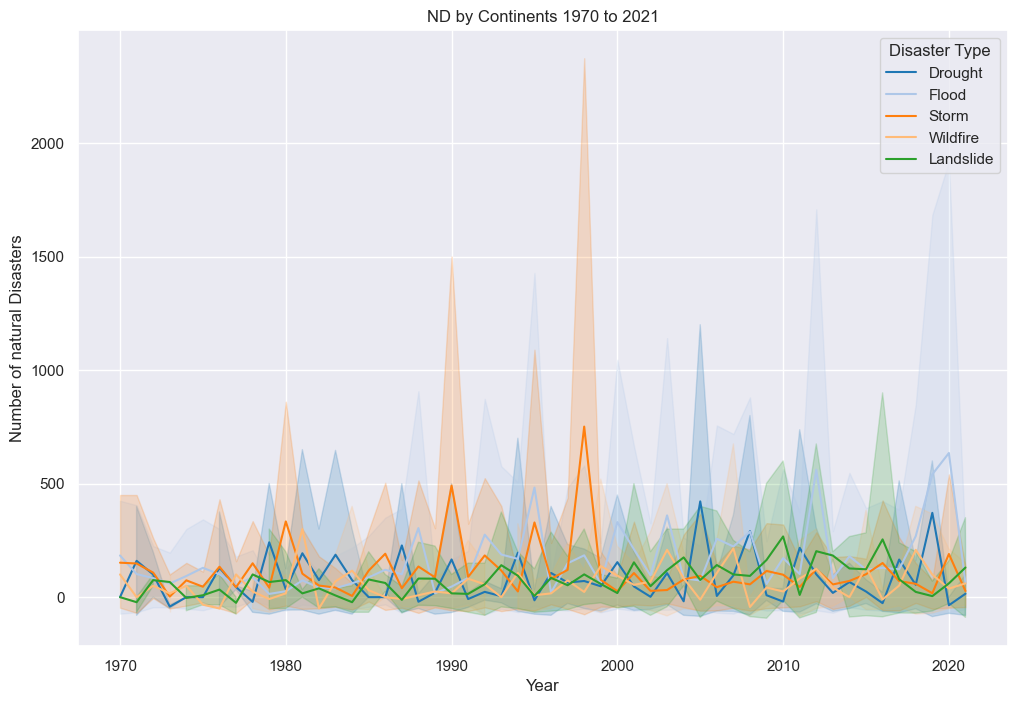

In [ ]:
sns.set_theme()
plt.figure(figsize=(12, 8))
sns.lineplot(data=df1, x="Year", y="% Difference from Previous Year", hue="Disaster Type", palette="tab20")
plt.xlabel("Year")
plt.ylabel("Number of natural Disasters")
plt.title("ND by Continents 1970 to 2021")
plt.show()

These next two graphs are for visual purposes and to see them more clearly. We will be comparing these two to emissions and temperatures side by side to see the full visual effect. I have made two lineplots based off of the natural disasters; the first one being the number of natural disasters over the years so we may see peaks on years where there was a significant increase. The second plot displays the difference in percentage in comparison to the previous year. I have organised the natural disaster's data so we can see five different types including droughts, floods, storms, wildfires, and landslides.

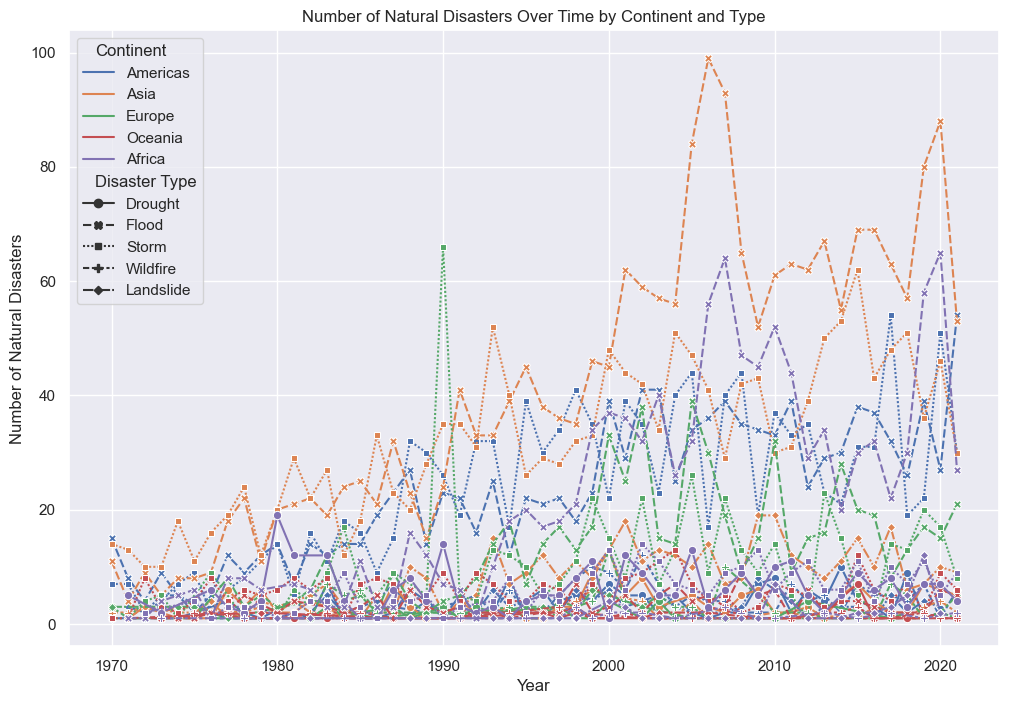

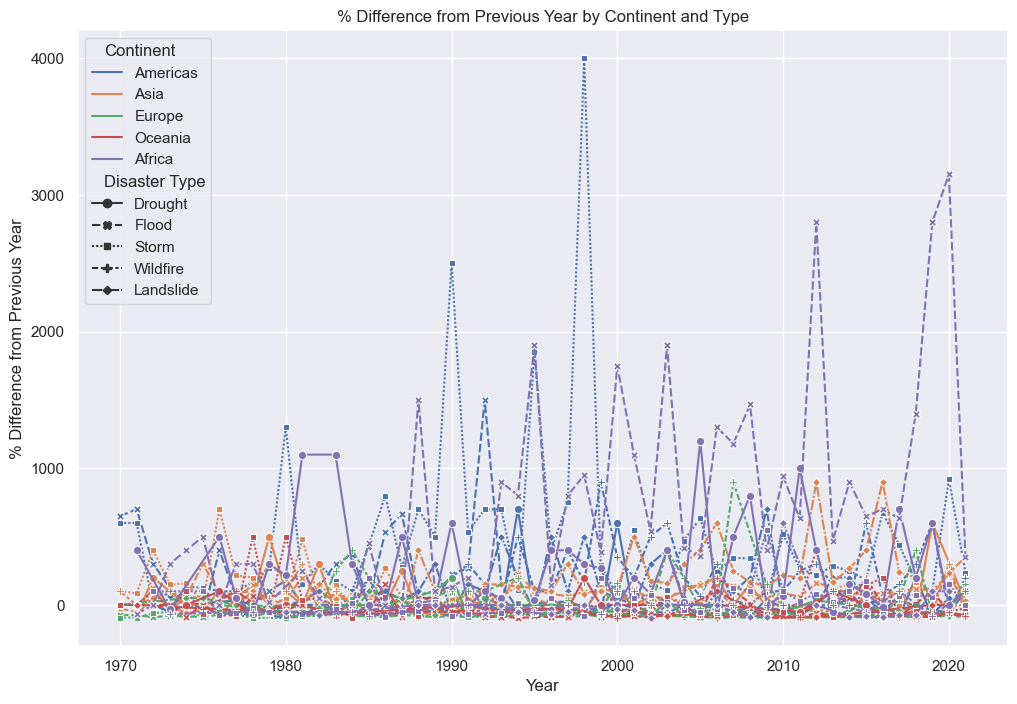

In [ ]:
# lineplot for # of natural disasters 
plt.figure(figsize=(12, 8))
sns.lineplot(data=df1, x="Year", y="Number of Disasters", hue="Continent", style="Disaster Type", markers=True)
plt.xlabel("Year")
plt.ylabel("Number of Natural Disasters")
plt.title("Number of Natural Disasters Over Time by Continent and Type")
plt.show()

# line plot for % difference of natural disasters
plt.figure(figsize=(12, 8))
sns.lineplot(data=df1, x="Year", y="% Difference from Previous Year", hue="Continent", style="Disaster Type", markers=True)
plt.xlabel("Year")
plt.ylabel("% Difference from Previous Year")
plt.title("% Difference from Previous Year by Continent and Type")
plt.show()

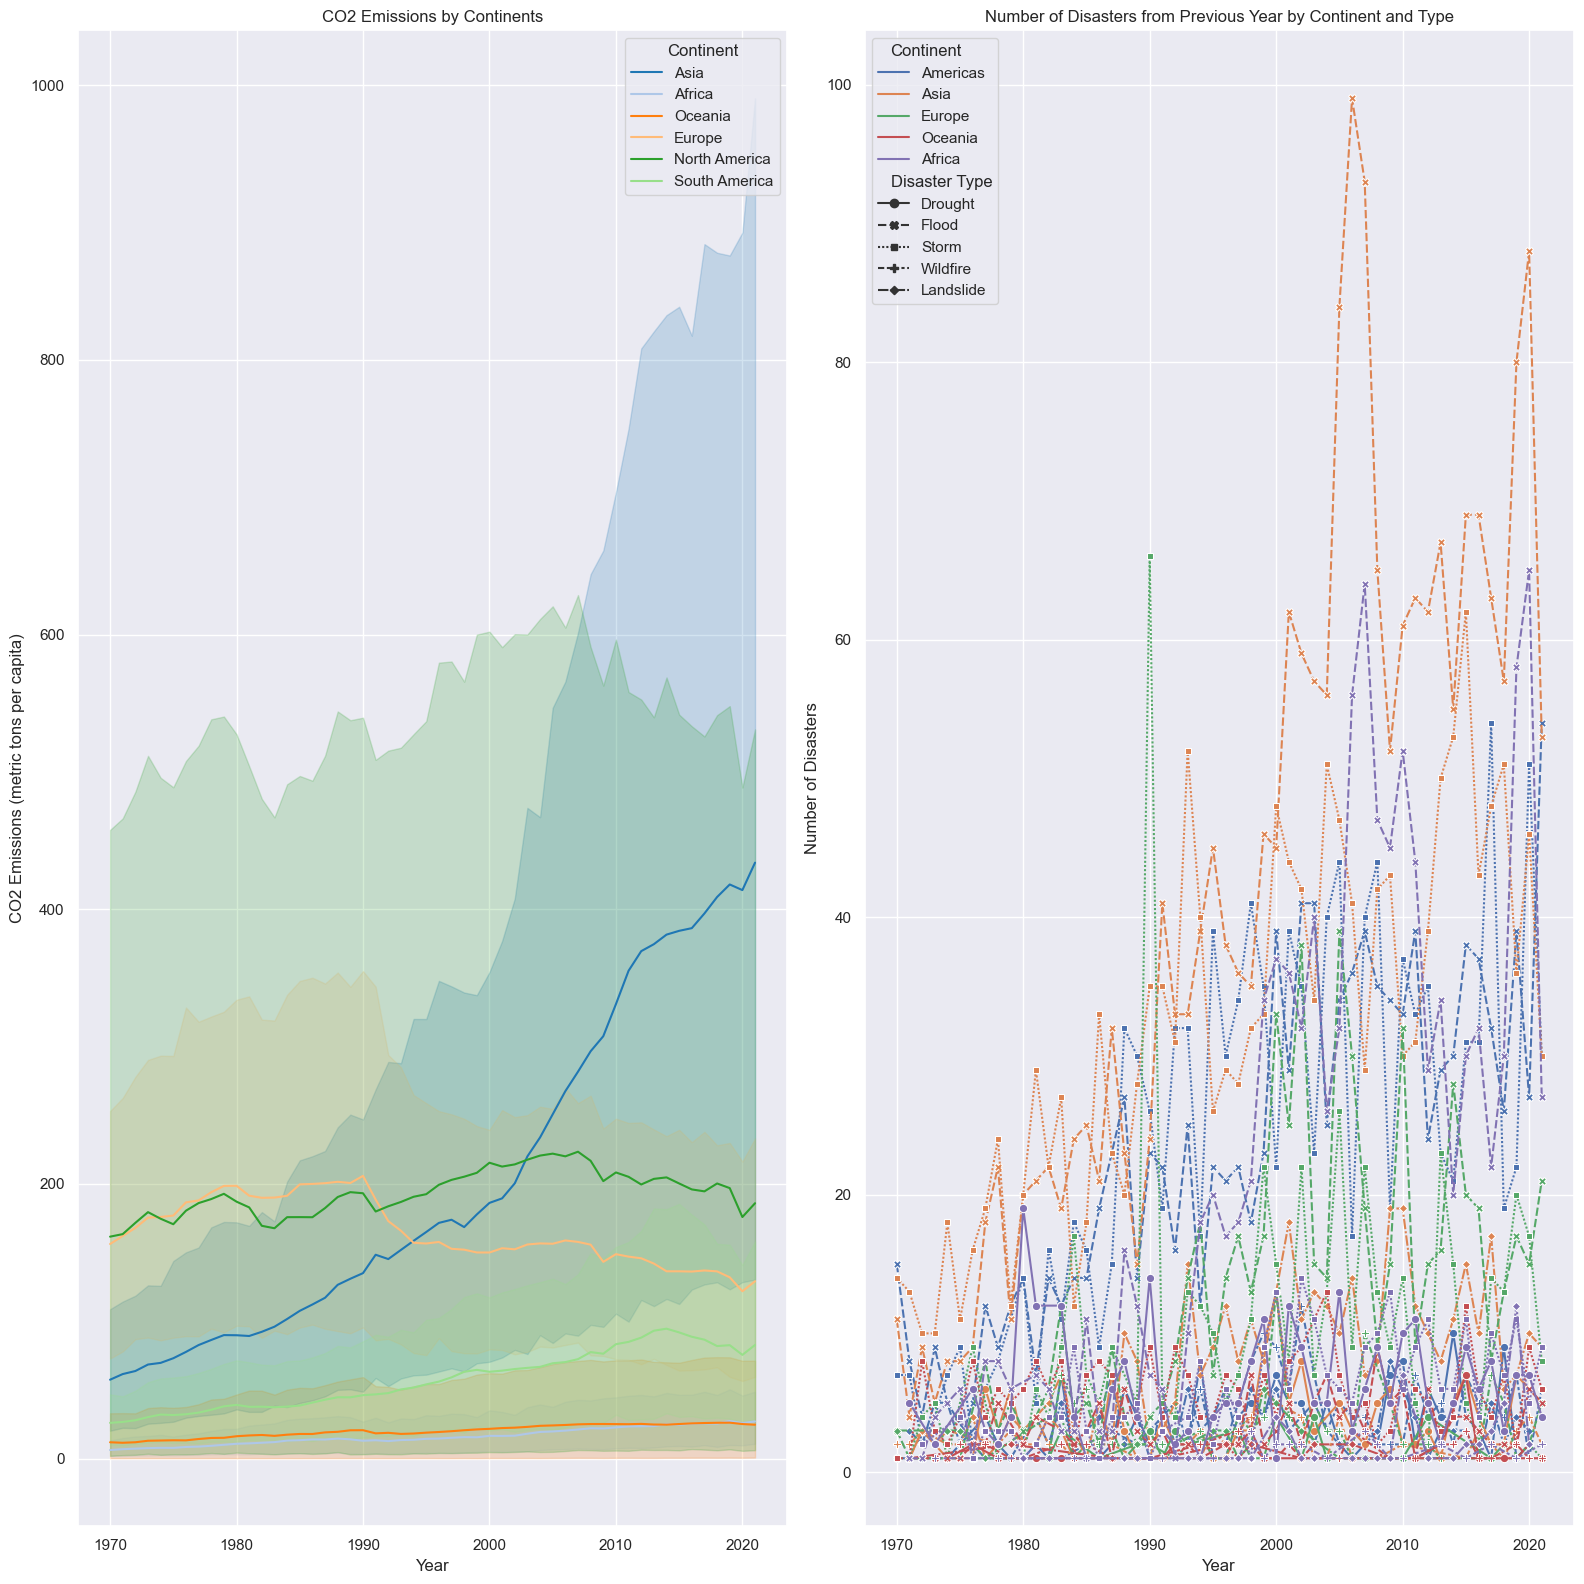

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
# ploting Emissions and Natural disaster's dataset side by side
# left plot: Emissions
sns.lineplot(data=df2, x="Year", y="co2", hue="Continent", palette="tab20", ax=axes[0])
axes[0].set_xlabel("Year")
axes[0].set_ylabel("CO2 Emissions (metric tons per capita)")
axes[0].set_title("CO2 Emissions by Continents")

# right plot: Natural Disasters
sns.lineplot(data=df1, x="Year", y="Number of Disasters", hue="Continent", style="Disaster Type", markers=True, ax=axes[1])
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Number of Disasters")
axes[1].set_title("Number of Disasters from Previous Year by Continent and Type")

plt.tight_layout()
plt.show()


At the begining of the 2000's, in the emission plot, we can see the surge in Asia's emission. Comparing to the natural disaster's plot on the right, we see that around the 2000's is also when the number of natural disasters began to increase. The relationship between Asia's increase in both of emissions and natural disasters seems to be significant.

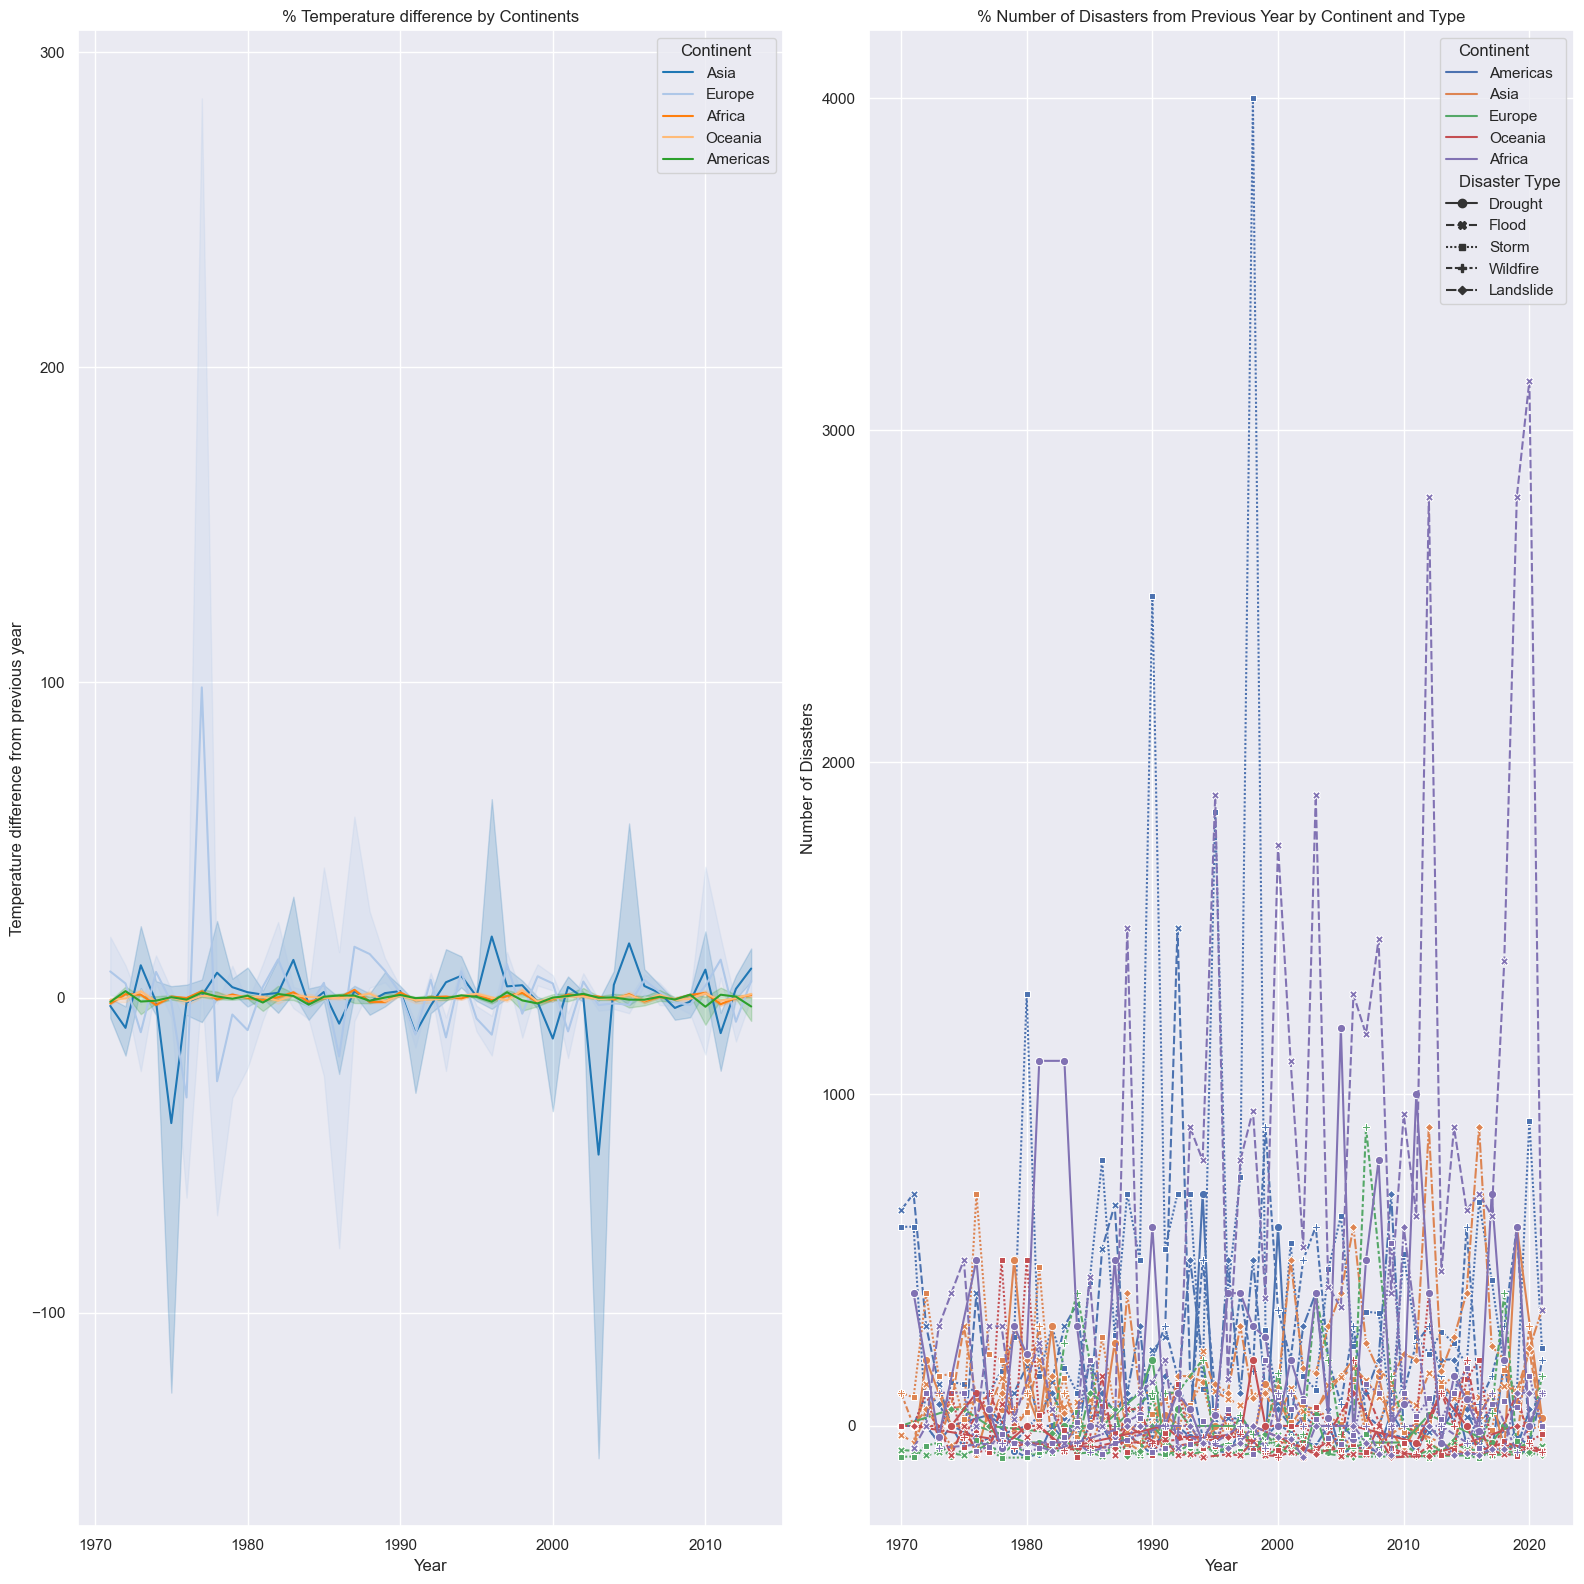

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
# ploting Temperature and Natural disaster's dataset side by side
# left plot: Temperature
sns.lineplot(data=df3, x="Year", y="% temp difference", hue="Continent", palette="tab20", ax=axes[0])
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Temperature difference from previous year")
axes[0].set_title("% Temperature difference by Continents")

# right plot: Natural Disasters
sns.lineplot(data=df1, x="Year", y="% Difference from Previous Year", hue="Continent", style="Disaster Type", markers=True, ax=axes[1])
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Number of Disasters")
axes[1].set_title("% Number of Disasters from Previous Year by Continent and Type")

plt.tight_layout()
plt.show()


The same patterns of increase around the 2000's can be seen here when comparing natural disasters percentage difference and temperatures percentage differences. It's pretty evident looking at the drastic changes in temperatures on the right, Asia is inconsistent with their yearly temperatures. This is an indication of the climate crisis due to its inconsistencies. Yet in contrast to the right, we have the difference of natural disasters per year with Asia increasing about the same percent each year consistently.

#### Let's plot out the number of natural disasters throughout 1970 to 2021:

Text(0.5, 1.0, 'Number of Natural Disasters Per Year')

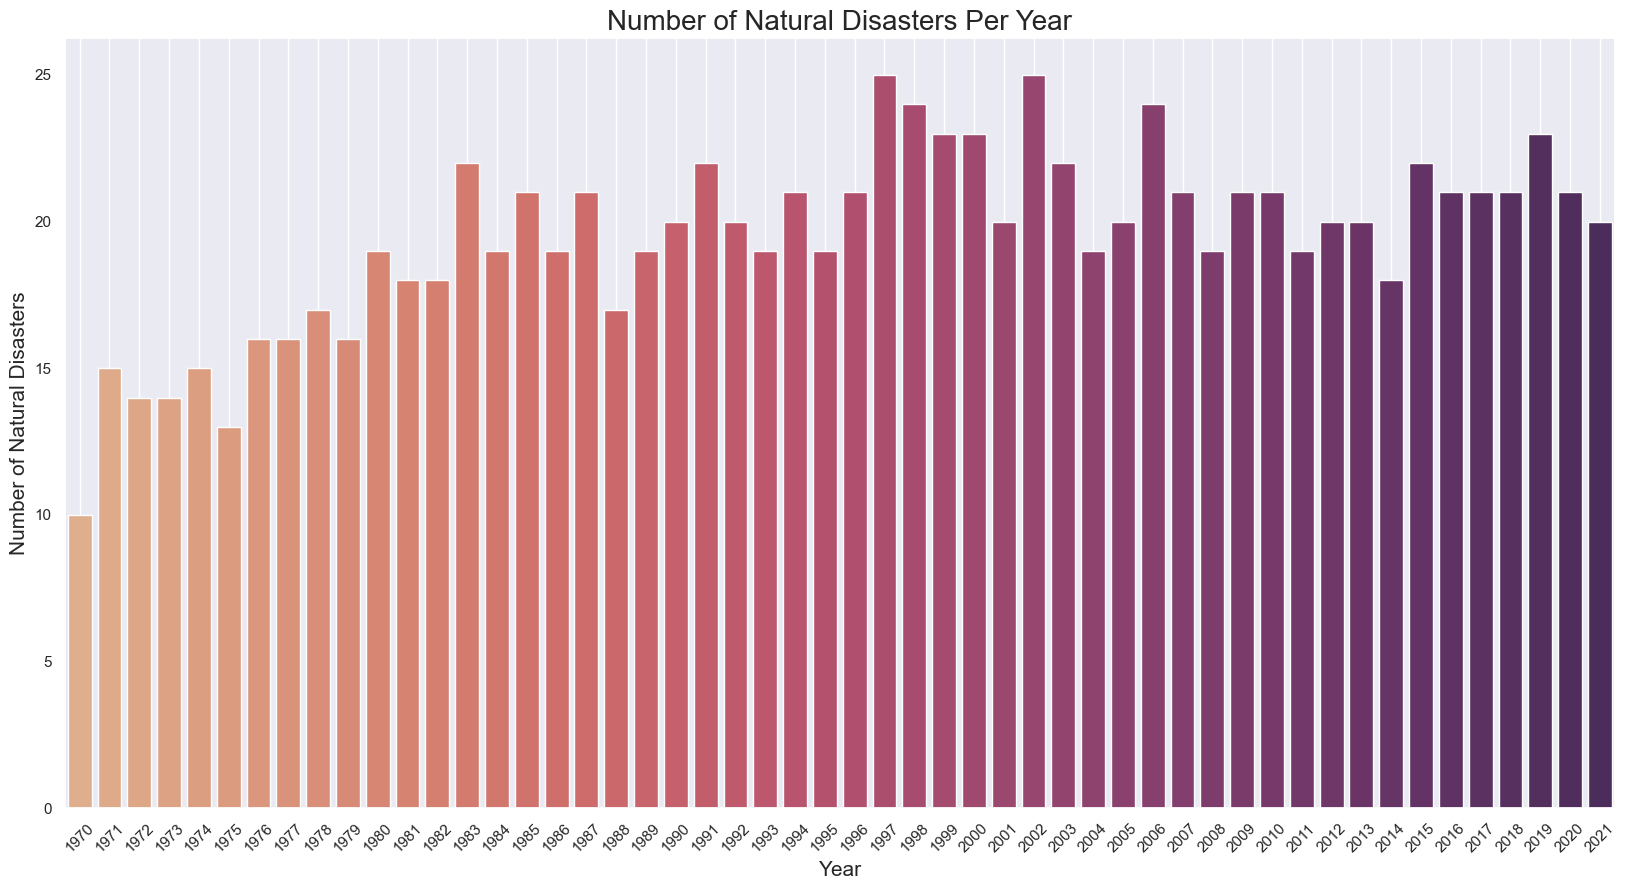

In [ ]:
plt.figure(figsize=(20,10))
ndplot = sns.countplot(data = df1, x='Year', palette = 'flare')
plt.xticks(rotation=45,fontsize = 11)
ndplot.grid()
ndplot.set_xlabel("Year", fontsize = 15)
ndplot.set_ylabel("Number of Natural Disasters", fontsize = 15)
plt.title("Number of Natural Disasters Per Year",fontsize = 20) # maybe change font size?


Text(0.5, 1.0, 'Number of Natural Disaster Types Per Year')

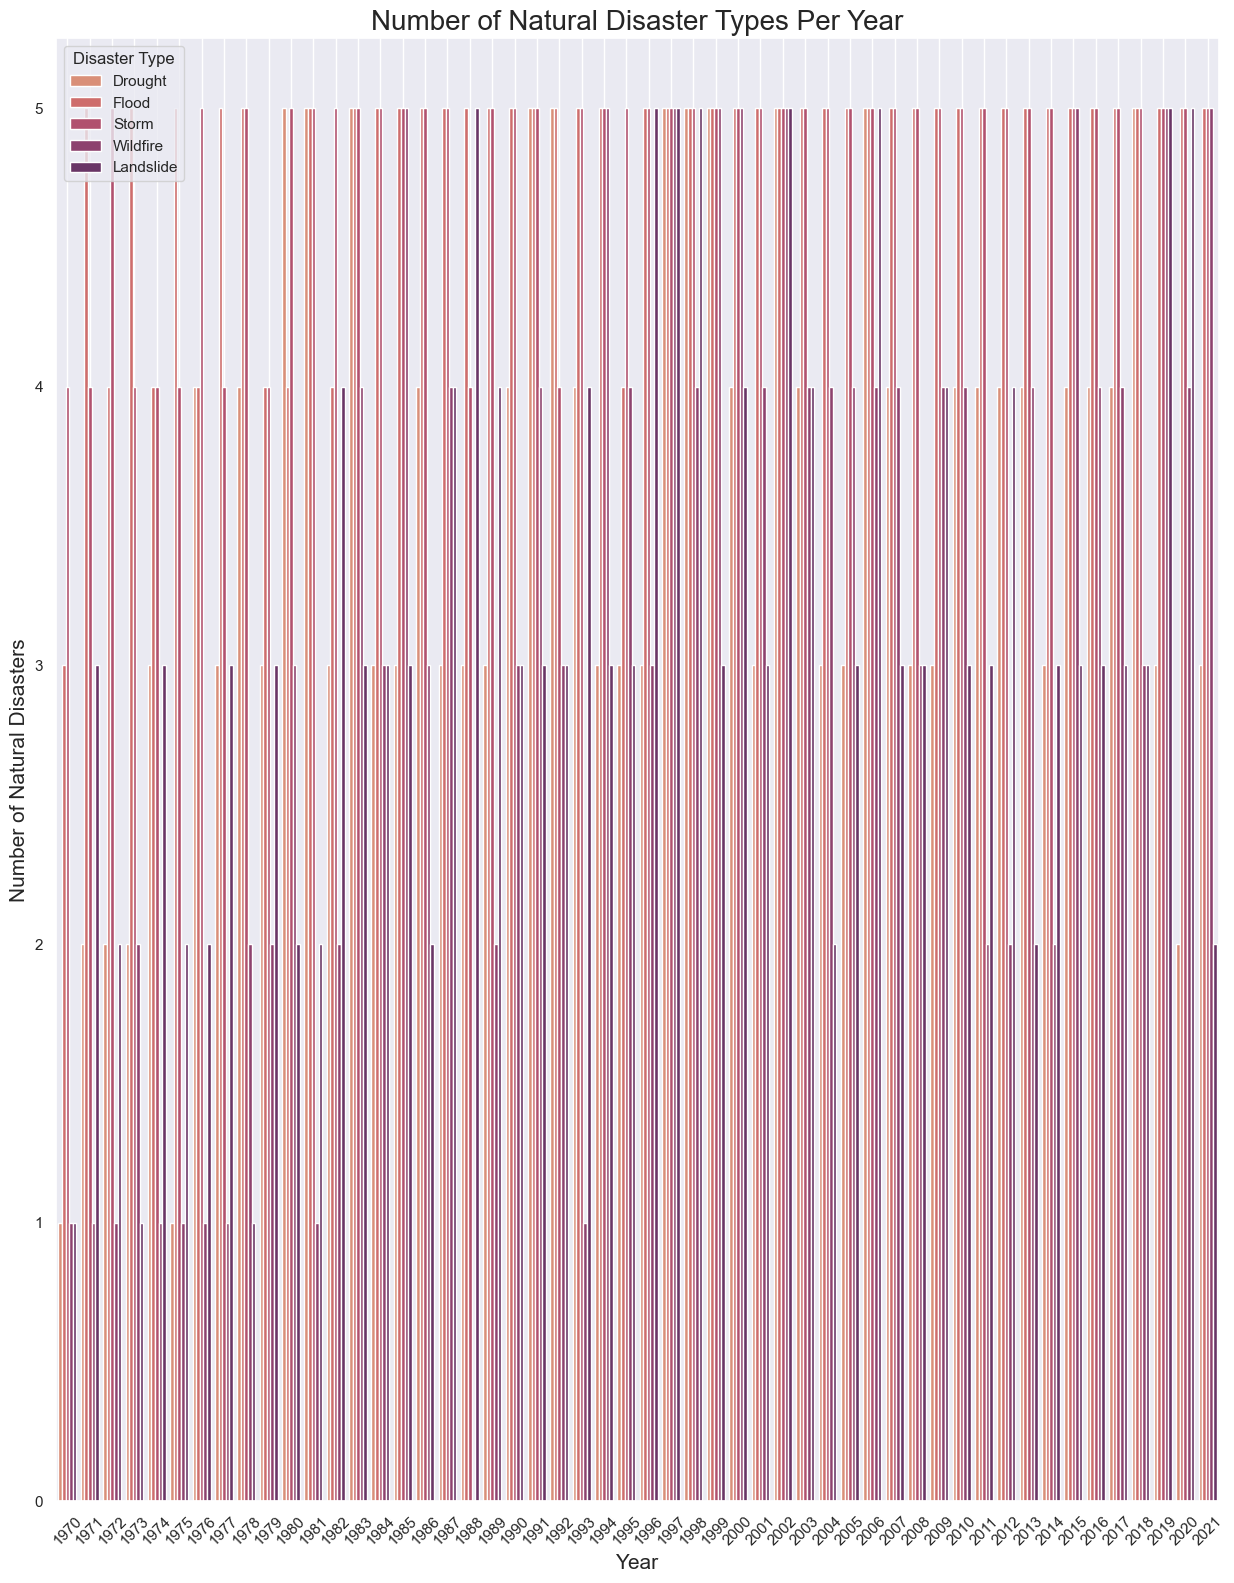

In [ ]:
plt.figure(figsize=(15,19))
ndplot = sns.countplot(data = df1, x='Year', hue = "Disaster Type", palette = 'flare')
plt.xticks(rotation=45,fontsize = 11)
ndplot.grid()
ndplot.set_xlabel("Year", fontsize = 15)
ndplot.set_ylabel("Number of Natural Disasters", fontsize = 15)
plt.title("Number of Natural Disaster Types Per Year",fontsize = 20)

In [ ]:
df1.to_csv("../data/processed/processedNatDisasterData.csv")
df2.to_csv("../data/processed/processedNatDisasterDataEmiss.csv")
df3.to_csv("../data/processed/processedNatDisasterDataTemp.csv")

After completing my exploratory data analysis, the data analysis suggests a positive relationship between natural disaster rates and emission rates, specifically in Asia, as well as a consistent pattern in the change in temperatures and difference of yearly natural disasters. The results of this analysis highlight the importance of reducing greenhouse gas emissions to mitigate the impact of natural disasters on communities and the environment. Although there may be other contributing factors to the reasons for which natural disaster rates have increased over the period of roughly 60 years.